## 3. Octave and one-third octave band filters

In this notebook we'll go through designing and appyling **fractional band-pass filtering** (mainly 1/1 and 1/3 octave filters) to our already processed signal.

Once we have applied a **frequency weighting filter to the signal** we can obtain a measure of the **global sound pressure level for a certain time interval of interest**. That's nice but, if we want to have **information as to the frequencies in which the measured signal has a high SPL** we need to split this global level in a per-frequency-band indicator.

For that, we will **apply band-pass filters to our signal**. The amount of pass-bands filters to apply will be determined by how many different frequency bands we'd like our measurement to be split in. We will explore **1/1 octave and 1/3 octave filters**, increasing three times the amount of bands for the latter.

## Filter specifications

The band-pass filters used for acoustical measurements are defined by the **IEC 61260 standard**. In it, the **templates that these filters should follow are specified**. The requirements are given in **two Class based on their performance: Class 1 and Class 2**. Both have the **same design objectives but they different in the acceptance limit**. 

Since the filters are defined on a logarithmic scale, **all filters of the same family should have the same response**. So, only one response is specified with the **mid-band frequency normalized to 1**.

For each of the filters, the **exact mid-band frequency** can be determined from the following expression: 

$$ f_m = f_rG^{x/b}, \ \text{when b is odd} $$

$$ f_m = f_rG^{(2x+1)/b}, \ \text{when b is even} $$

Where $ f_r $ is the **reference frequency**, $ G = 10^{0.3} $ is the **octave frequency ratio** (that represents the distance between frequencies that is equal to an octave band), and $ 1/b $ is the **bandwidth designator** (1/1 for octave and 1/3 for third-octave bands, and so on).

Next, we'll bring over these variables that will allow us to visualize and build our filters.

In [46]:
import numpy as np

# Reference frequency
FR = 1000.0

# Octave frequency ratio
G = 10**(3/10)

# Exact third-octave mid-band frequencies
fto_mid = np.array([FR*G**(x/3) for x in np.arange(33)-19])

# Exact octave band mid-band frequencies
foct_mid = np.array([FR*G**(x) for x in np.arange(11)-6])

# Nominal third-octave mid-band frequencies
fto_nom = np.array([ 12.5, 16.0, 20.0, 25.0, 31.5, 40.0, 50.0, 63.0, 80.0, 100.0, 
                    125.0, 160.0, 200.0, 250.0, 315.0, 400.0, 500.0, 630.0, 800.0, 
                    1000.0, 1250.0, 1600.0, 2000.0, 2500.0, 3150.0, 4000.0, 5000.0,
                    6300.0, 8000.0, 10000.0, 12500.0, 16000.0, 20000.0])

# Nominal octave band mid-band frequencies
foct_nom = fto_nom[1::3]

Great! Now we have both the **nominal and exact mid-band frequencies for both the octave and third-octave frequency filters**. 

## Plotting the filter templates

Before moving on to calculating the **upper and lower boundary frequencies**, we'll get the standard's specification for designing the filters and **plot the templates for the Class 1 octave and third-octave band-pass filters**.

(0.5, 2)

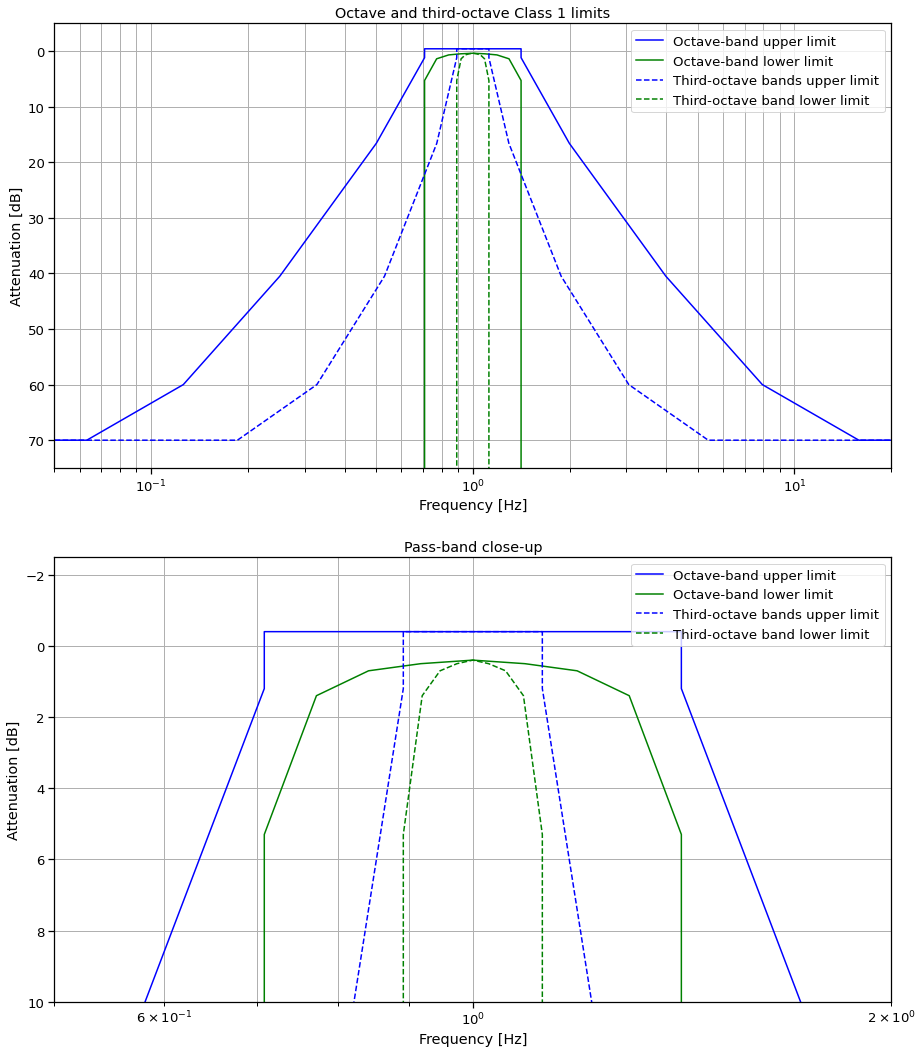

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (15,9)
sns.set_context('notebook', font_scale=1.2)

# minimum absolute representable float
eps = np.finfo(float).eps

# a very big number
inf = 10**5

# Standard definitions
# - - - - - - - - - - - - - - - 

# Octave-band frequency array
x_t_oct = np.array([-inf, G**-4, G**-3, G**-2, 
                    G**-1, G**(-1/2-eps), G**(-1/2+eps),
                    G**(-3/8), G**(-1/4), G**(-1/8),
                    1, G**(1/8), G**(1/4), G**(3/8),
                    G**(1/2-eps), G**(1/2+eps), G**1,
                    G**2, G**3, G**4, inf])

# Third-octave band frequency array
x_t_to = np.array([-inf, 0.18546, 0.32748, 0.53143, 0.77257, 
                   0.89125-eps, 0.89125+eps, 0.91958, 0.94719, 
                   0.97402, 1, 1.02667, 1.05575, 1.08746, 
                   1.12202-eps, 1.12202+eps, 1.29437, 
                    1.88173, 3.05365, 5.39195, inf])

# Class 1 upper tolerance
y_upp = np.array([70, 70, 60, 40.5, 16.6, 1.2, -0.4, -0.4, 
                  -0.4, -0.4, -0.4, -0.4, -0.4, -0.4, 
                  -0.4, 1.2, 16.6, 40.5, 60, 70, 70])

# Class 1 lower tolerance
y_low = np.array([inf, inf, inf, inf, inf, inf, 5.3, 1.4,
                  0.7, 0.5, 0.4, 0.5, 0.7, 1.4, 5.3, 
                  inf, inf, inf, inf, inf, inf])

# Plotting
# - - - - - - - - - - - - - - - 

fig, ax = plt.subplots(2, 1, figsize=(15,18))

for ax_ in ax:
    ax_.plot(x_t_oct, y_upp, c='b', label='Octave-band upper limit')
    ax_.plot(x_t_oct, y_low, c='g', label='Octave-band lower limit')
    ax_.plot(x_t_to, y_upp, '--', c='b', label='Third-octave bands upper limit')
    ax_.plot(x_t_to, y_low, '--', c='g', label='Third-octave band lower limit')
    ax_.set_xscale('log')
    ax_.grid('on', which='both')
    ax_.legend()
    ax_.set_xlabel('Frequency [Hz]')
    ax_.set_ylabel('Attenuation [dB]')
    
ax[0].set_title('Octave and third-octave Class 1 limits')
ax[1].set_title('Pass-band close-up')

ax[0].set_ylim([75, -5])
ax[0].set_xlim([5*10**-2, 20])

ax[1].set_ylim([10, -2.5])
ax[1].set_xlim([5*10**-1, 2])

Having our **Class 1 templates for all of the filters belonging to the families of octave and third-octave band-pass filters** we only need to, well desing our filters!

## Designing the filters

For that, we need the **upper and lower edge-band frequencies for each filter** which can be calculated respectively with the equations below:

$$ f_1 = f_mG^{-1/(2b)} $$
$$ f_2 = f_mG^{+1/(2b)} $$

By means of the `butter` function and based on these frequencies we can get the **coefficients for a second-order-section implementation of a IIR Butterworth filter**. The **Butterworth filters** offer the advantage of having a **frequency response as flat as possible in the passband**.

Next, we'll compute the edge-band frequencies and then build a **function based on** `butter` **that will yield these coefficients**-

In [123]:
from scipy.signal import butter

# Octave-band upper and lower frequencies
foct_1 = foct_mid*G**(-1/2)
foct_2 = foct_mid*G**(1/2)

# Third octave-band upper and lower frequencies
fto_1 = fto_mid*G**(-1/(2*3))
fto_2 = fto_mid*G**(1/(2*3))

def but_pb(low, upp, fs=FS, order=4):
    """ Returns the coefficients to a second-order-section 
    Butterworth band-pass filter. The filter is built with 
    'order' orders and according to the upper and lower 
    edge-band frequencies ('low' and 'up'). """
    nyq = 0.5*fs
    f1 = low/nyq
    f2 = upp/nyq
    sos = butter(order, [f1, f2], btype='band', output='sos')
    return sos

In [120]:


def but_pb_filt(x, f1, f2, fs=fs, order=4):
    """ Filtrado de la señal. """
    sos = but_pb(inf, sup, fs=fs, order=order)
    return sosfilt(sos, x)

def filt_to(x, fto_nom=fto_nom):
    """ Filtrado de la señal de entrada 'x' por bandas de tercio de octava.
    Permite el ingreso del valor nominal de las frecuencias centrales para las
    bandas deseadas, 'fto_nom'. Por defecto 25 Hz < f < 10 kHz. """
    fto_inf, fto_sup = fto_lim(fto_nom)
    y = np.empty([len(fto_nom),len(x)])
    for i in range(len(fto_nom)):
        y[i] = np.reshape(but_pb_filt(x, fto_inf[i], fto_sup[i]), -1)
    return y